## Introduction - Machine Learning on BDTI

The aim of this use case is to build a dashboard that can be used to inform decisions on public lighting. <br>
The dashboard shows the effect of turning off public lighting during certain hours for the coming week, using adjustable settings. <br>
The dashboard will also contain a map that displays exactly which streetlights are on and which are off depending on the setting. <br>
This is what the dashboard will look like:

<div>
    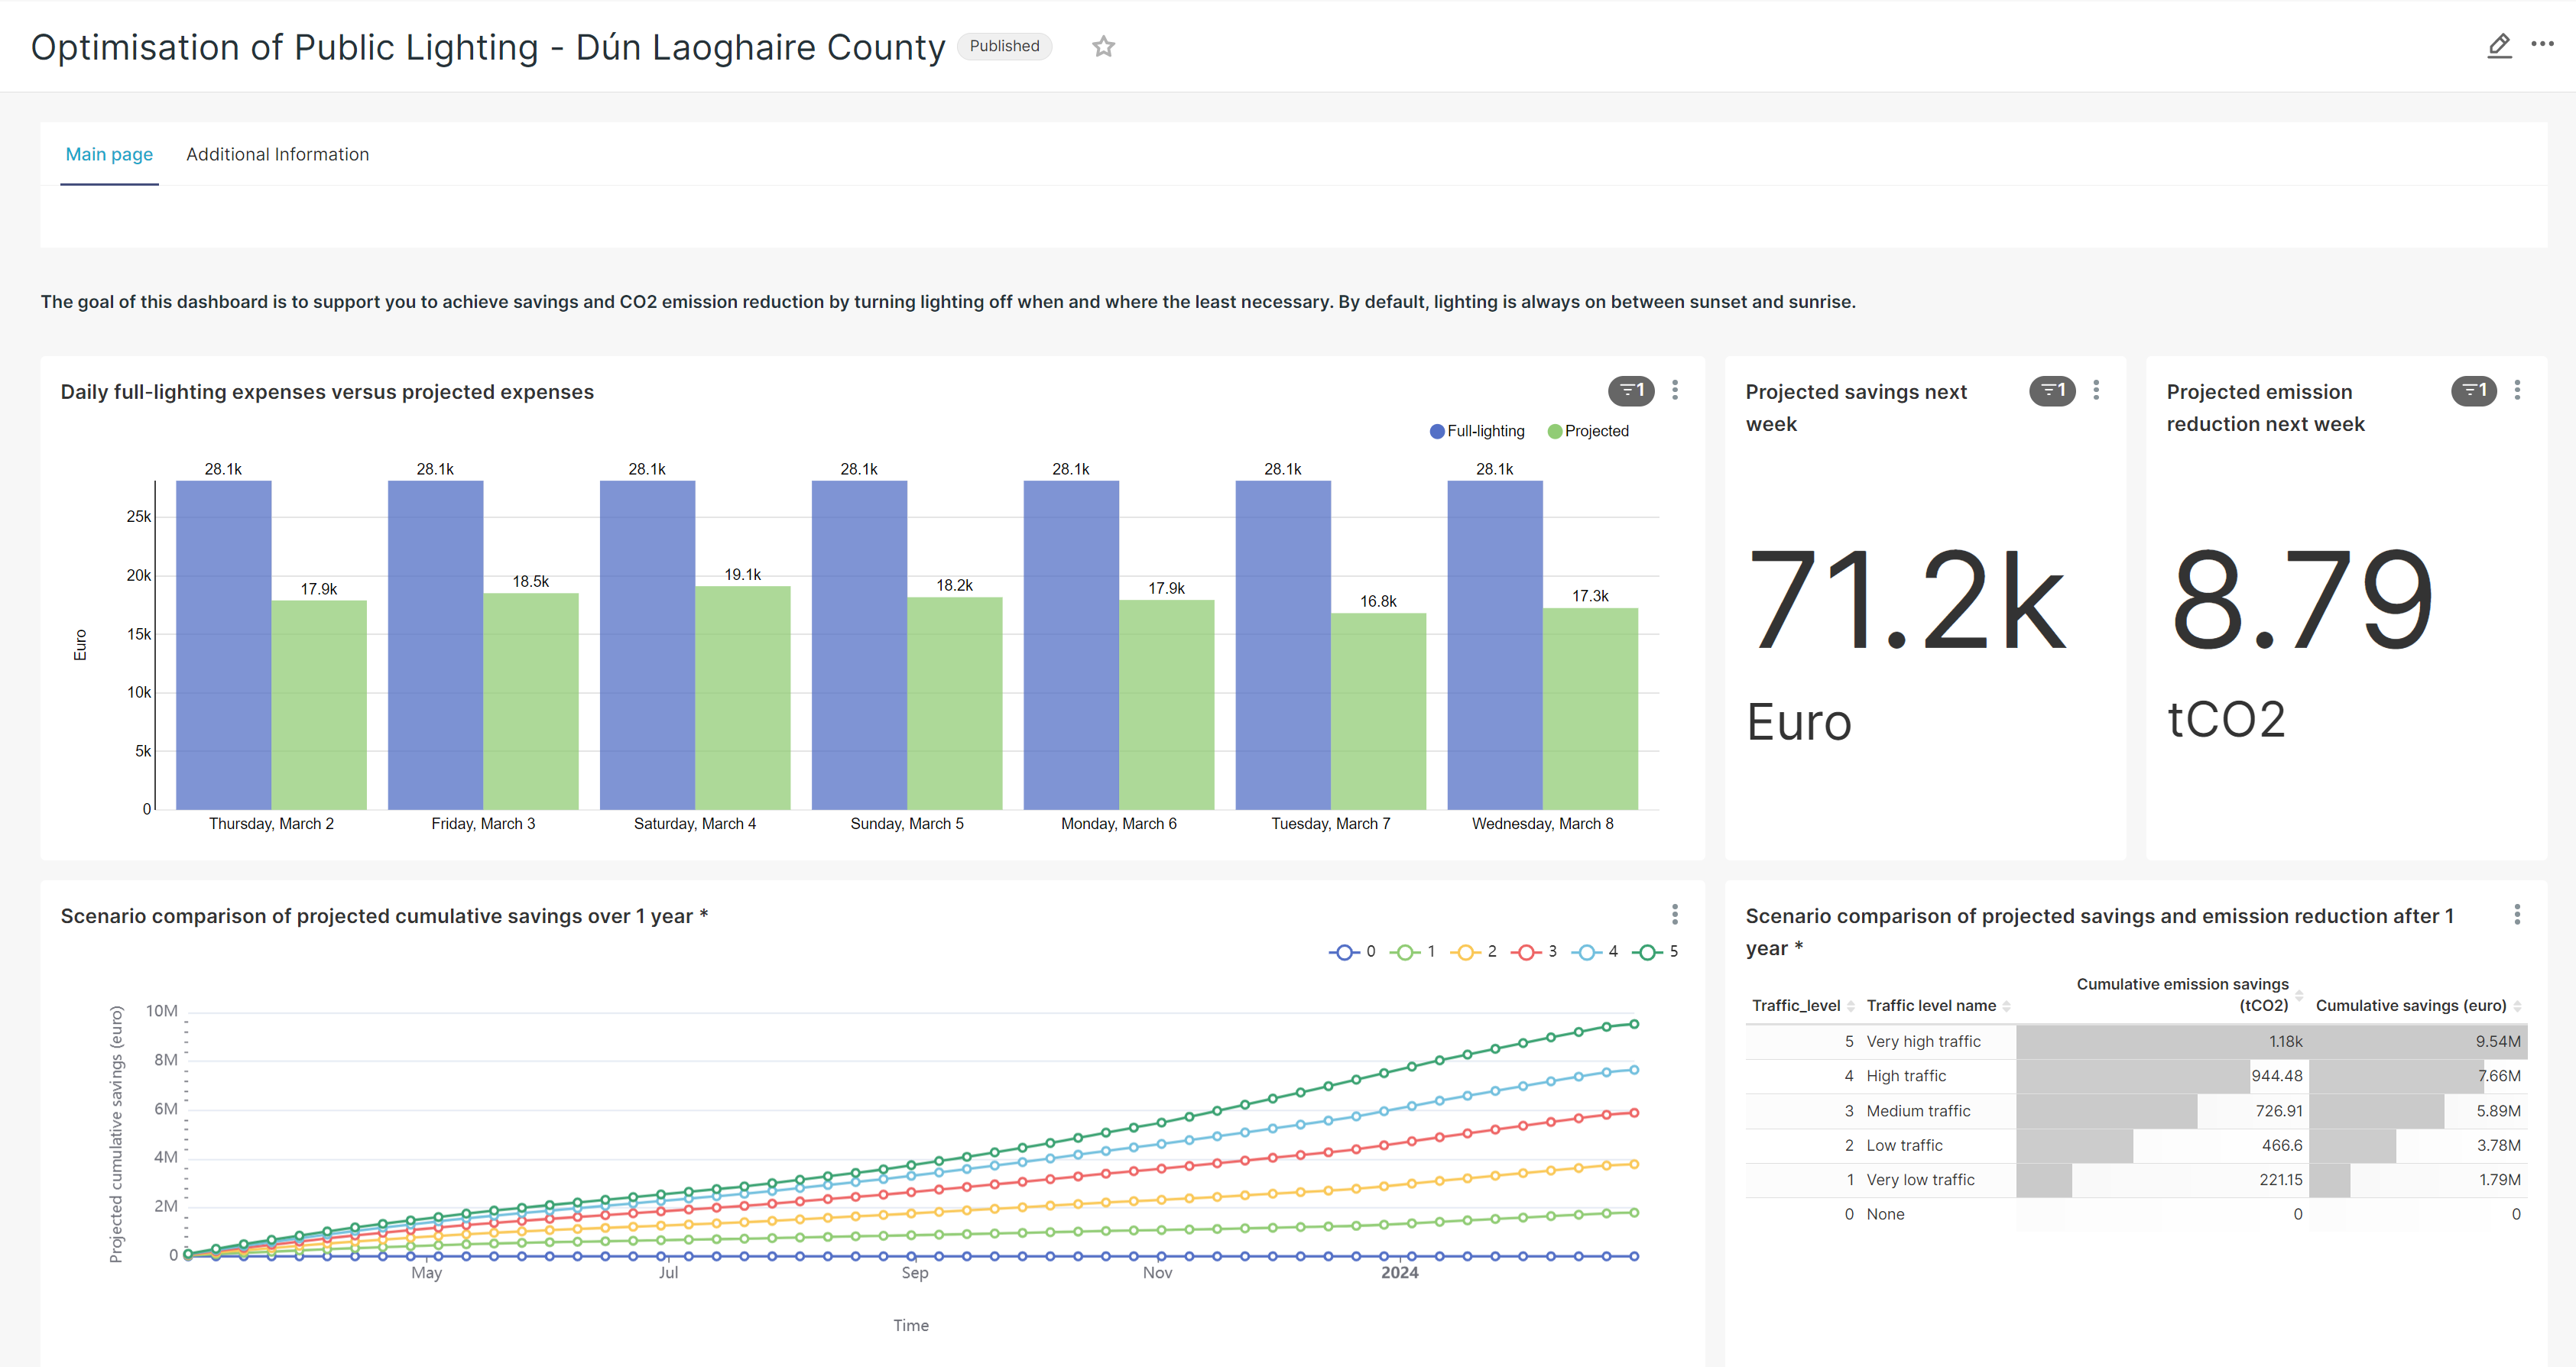
</div>

The data underlying the dashboard is:
- Weather forecast for the coming week
- Hourly predicted traffic volumes for the coming week
- Locations of streetlights

The hourly predicted traffic volumes will be the output of the machine learning model. The weather forecast will be downloaded from an API. The data related to the locations of streetlighting and on how traffic is distributed over all streets is directly available in csv files.

This use-case consists of three scripts
- Part 1: 1_data_collection_and_preprocessing.ipynb
- Part 2: 2_training_ml_model.ipynb
- Part 3: 3_run_model.ipynb

Each of these scripts contains text that will explain what is happening.

Besides scripts there are also three datafiles needed:
- traffic_fractions.csv
- streetlight_locations.csv
- historical_traffic_data.csv

Make sure these datafiles are placed in a folder called 'data'. Your folder should look like this:

<div>
    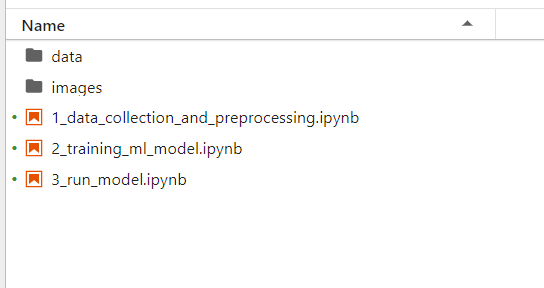
</div>

## Part One - Data collection and preprocessing

The machine learning model will predict the hourly total traffic volume for the coming week. The model inputs will be weather and datetime parameters. <br>
The model will be trained on weather and traffic data from 2020, 2021 and 2022.

In this part we will:
 1. Download historical weather data for the city of Dublin
 2. Preprocess the historical weather data to match our purposes
 3. Use the astronomy package 'astral' to enrich the data. We want to know whether the sun was up.
 4. Enrich the data with the hourly traffic volumes of Dublin

In [1]:
# 1) import relevant packages

import pandas as pd
import numpy as np
import urllib.request
import urllib.parse
import zipfile
import requests
import httpio
import csv
from io import BytesIO, StringIO
from datetime import date
import astral
import calendar

In [2]:
# If you get an error, possibly you will need to install the packages below. 
# In that case, uncomment the lines below and run this cell.

#!pip install astral==1.10.1
#!pip install openpyxl
#!pip install httpio

# Once this is done, re-run cell 1 above to import all the relevant packages

In [3]:
# 2) download historical weather data from the meterological institute of Ireland:

url = "https://cli.fusio.net/cli/climate_data/webdata/hly532.zip"
with httpio.open(url) as fp:
    zf = zipfile.ZipFile(fp)
    print(zf.namelist())
    zf.extractall()

In [4]:
# 3) open and inspect the historical weather data

histweather = pd.read_csv('hly532.csv',delimiter=';')
pd.set_option('display.max_rows', 50, 'display.min_rows',20)
histweather.head(30)

Station Name: DUBLIN AIRPORT
0                               Station Height: 71 M 
1                 Latitude:53.428  ,Longitude: -6.241
2                       date:  -  Date and Time (utc)
3             rain:  -  Precipitation Amount (mm)\t  
4                     temp:  -  Air Temperature (C)\t
5                  wetb:  -  Wet Bulb Temperature (C)
6    dewpt: -  Dew Point Temperature (C)             
7                     rhum:  -  Relative Humidity (%)
8                  vappr: -  Vapour Pressure (hPa)\t 
9             msl:   -  Mean Sea Level Pressure (hPa)
10                   wdsp:  -  Mean Wind Speed (knot)
11      wddir: -  Predominant Wind Direction (degree)
12           ww:    -  Synop code for Present Weather
13              w:     -  Synop code for Past Weather
14                sun:   -  Sunshine duration (hours)
15                           vis:   -  Visibility (m)
16  clht:  -  Cloud height (100's of ft) - 999 if ...
17                             clamt: -  Cloud amount
18                                ind:   -  Indicator
19  date,ind,rain,ind,temp,ind,wetb,dewpt,vappr,rh...
20  01-jan-1943 00:00,0,0.4,0,7.2,0,6.8,6.1,9.5,93...
21  01-jan-1943 01:00,0,0.7,0,7.8,0,7.6,7.2,10.2,9...
22  01-jan-1943 02:00,0,0.5,0,8.7,0,8.3,7.7,10.7,9...
23  01-jan-1943 03:00,2,0.0,0,9.1,0,8.7,8.3,11.0,9...
24  01-jan-1943 04:00,2,0.0,0,9.4,0,8.8,8.3,10.9,9...
25  01-jan-1943 05:00,2,0.0,0,9.4,0,8.7,7.7,10.7,9...
26  01-jan-1943 06:00,0,0.0,0,9.4,0,8.7,7.7,10.7,9...
27  01-jan-1943 07:00,2,0.1,0,9.4,0,8.6,7.7,10.5,8...
28  01-jan-1943 08:00,0,0.4,0,9.6,0,8.9,8.3,10.9,9...
29  01-jan-1943 09:00,0,0.2,0,10.1,0,9.1,7.7,10.8,...

So, the data contains some rows of information on the weather station (rows 0 and 1), and some explaination of the measured parameters (rows 2-18). 
The actual data starts from row 20, with row 19 being headers. We need to extract the actual data.

In [5]:
# 4) split the data in the real data and the other info:

datainf = histweather.loc[0:18]
wdf = histweather.loc[19:]

# split the data based on the delimiter ',' and set the first row as headers
wdf = wdf.iloc[:,0].str.split(',',expand=True)
new_headers = wdf.iloc[0]
wdf = wdf[1:]
wdf.columns = new_headers

wdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701936 entries, 20 to 701955
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    701936 non-null  object
 1   ind     701936 non-null  object
 2   rain    701936 non-null  object
 3   ind     701936 non-null  object
 4   temp    701936 non-null  object
 5   ind     701936 non-null  object
 6   wetb    701936 non-null  object
 7   dewpt   701936 non-null  object
 8   vappr   701936 non-null  object
 9   rhum    701936 non-null  object
 10  msl     701936 non-null  object
 11  ind     701936 non-null  object
 12  wdsp    701936 non-null  object
 13  ind     701936 non-null  object
 14  wddir   701936 non-null  object
 15  ww      701936 non-null  object
 16  w       701936 non-null  object
 17  sun     701936 non-null  object
 18  vis     701936 non-null  object
 19  clht    701936 non-null  object
 20  clamt   701936 non-null  object
dtypes: object(21)
memory usage: 112.

Now we have extracted all weather data for dublin since 1942 (hourly!). We want to select only data from 2020-2022 and remove weather parameters that we won't use. The parameters we will use for machine learning are:
 - date (hourly datetime)
 - rain (percipation in mm)
 - temp (temperature in C)
 - wdsp (windspeed in knots)
 - vis (visibility in m)
 - clamt (cloudcover (%))

In [6]:
# 5) change the type of the date column to datetime and select the years from 2020 onwards

wdf['date'] = pd.to_datetime(wdf['date'])
wdf = wdf.loc[wdf['date'].dt.year>=2020]
wdf.reset_index(drop=True, inplace=True)

In [7]:
# 6) drop the parameters that are not being used in the ML model:

weather = wdf.drop(['ind','ind','wetb','wetb','dewpt','vappr','rhum','msl','ind','ind','wddir','ww','w','sun','clht'], axis=1)
weather.head()

19                date rain temp wdsp    vis clamt
0  2020-01-01 00:00:00  0.0  6.9    4  25000     7
1  2020-01-01 01:00:00  0.0  6.9    4  20000     7
2  2020-01-01 02:00:00  0.0  6.3    6  20000     7
3  2020-01-01 03:00:00  0.0  4.7    4  15000     3
4  2020-01-01 04:00:00  0.0  0.6    3  15000     1

We have now selected the data we need from the historical dataset. What is left is to enrich this data with:
1. A column [light] that has a value of 1 when it is dark and a value of 0 when it is light outside.
2. The traffic volumes per hour

We will use the package astral to calculate whether the sun was up during the hours in our dataset.
Let's have a look at what the package does.

In [8]:
# 7) set the location to Dublin and check the outcomes for today:

loc = astral.Location(('Dublin', 'Ireland', 53.21, -6.15, 'Europe/London'))
for event, time in loc.sun(date.today()).items():
    print(event, 'at', time)

dawn at 2023-03-01 06:38:30+00:00
sunrise at 2023-03-01 07:13:24+00:00
noon at 2023-03-01 12:37:03+00:00
sunset at 2023-03-01 18:00:43+00:00
dusk at 2023-03-01 18:35:37+00:00


In [9]:
# 8) calculate the hour of sunrise and the hour of sunset for the [date] column and round based on minutes

risehours = weather['date'].apply(lambda x: loc.sunrise(x).hour)
riseminutes = weather['date'].apply(lambda x: loc.sunrise(x).minute)
realrise = round(risehours+(riseminutes/60))

sethours = weather['date'].apply(lambda x: loc.sunset(x).hour)
setminutes = weather['date'].apply(lambda x: loc.sunset(x).minute)
realset = round(sethours+(setminutes/60))

In [10]:
# 9) based on the dusk and dawn times, decide if it's light or dark outside

weather['sunrise'] = realrise
weather['sunset'] = realset

def lightswitch(df):
    if (df['sunrise']<=df['date'].hour<df['sunset']):
        return '0'
    else:
        return '1'
    
weather['light'] = weather.apply(lightswitch, axis=1)
weather.drop(['sunrise','sunset'],axis=1,inplace=True)

The data contains one column [date] with all the info on the data and time. In the machine learning mode, we expect the month of the year, day of the week, and hour of the day to influence the prediction for traffic volumes. We therefore put these parameters into seperate columns. This will also help us later when we evaluate the importances of the feature variables.

In [11]:
# 10) put data attributes into seperate columns

weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month
weather['day'] = weather['date'].dt.day_name()
weather['hour'] = weather['date'].dt.hour
weather.head()

19                date rain temp wdsp    vis clamt light  year  month  \
0  2020-01-01 00:00:00  0.0  6.9    4  25000     7     1  2020      1   
1  2020-01-01 01:00:00  0.0  6.9    4  20000     7     1  2020      1   
2  2020-01-01 02:00:00  0.0  6.3    6  20000     7     1  2020      1   
3  2020-01-01 03:00:00  0.0  4.7    4  15000     3     1  2020      1   
4  2020-01-01 04:00:00  0.0  0.6    3  15000     1     1  2020      1   

19        day  hour  
0   Wednesday     0  
1   Wednesday     1  
2   Wednesday     2  
3   Wednesday     3  
4   Wednesday     4

So we added a boolean column [light] that is 0 during the light of day and 1 during the dark. Now we will download traffic data and merge it with the historical weather data.

In [12]:
# 11) download the historical traffic data and inspect it

traffic = pd.read_csv('data/historical_traffic_data.csv', sep=',')
traffic['date'] = pd.to_datetime(traffic['End_Time'])
traffic.info()
traffic.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24889 entries, 0 to 24888
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   End_Time      24889 non-null  object        
 1   Total_Volume  24889 non-null  int64         
 2   date          24889 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 583.5+ KB


End_Time  Total_Volume                date
0  2020-01-01 01:00:00        102639 2020-01-01 01:00:00
1  2020-01-01 02:00:00        114713 2020-01-01 02:00:00
2  2020-01-01 03:00:00        101060 2020-01-01 03:00:00
3  2020-01-01 04:00:00         91551 2020-01-01 04:00:00
4  2020-01-01 05:00:00         83693 2020-01-01 05:00:00

You can see that 'historical_traffic_data.csv' contain the total traffic volume on an hourly basis. The hours in the traffic data largely match the hours in the processed weather data. We will use an inner join to create a merged dataset having only the hours that exist in both datasets.

In [13]:
# 12) we join the weather data with the traffic data using an inner join

jdf = weather.join(traffic.set_index('date'), on='date', how = 'inner')
jdf.drop(['End_Time'], axis=1, inplace=True)
jdf.rename(columns={'Total_Volume':'total_traffic_volume'},inplace=True)
jdf.head(25)

date rain temp wdsp    vis clamt light  year  month  \
1  2020-01-01 01:00:00  0.0  6.9    4  20000     7     1  2020      1   
2  2020-01-01 02:00:00  0.0  6.3    6  20000     7     1  2020      1   
3  2020-01-01 03:00:00  0.0  4.7    4  15000     3     1  2020      1   
4  2020-01-01 04:00:00  0.0  0.6    3  15000     1     1  2020      1   
5  2020-01-01 05:00:00  0.0  1.5    3  15000     1     1  2020      1   
6  2020-01-01 06:00:00  0.0  2.5    3  18000     1     1  2020      1   
7  2020-01-01 07:00:00  0.0  0.6    6  15000     1     1  2020      1   
8  2020-01-01 08:00:00  0.0  2.1    4  15000     5     1  2020      1   
9  2020-01-01 09:00:00  0.0  2.2    4   8000     5     0  2020      1   
10 2020-01-01 10:00:00  0.0  1.7    3  12000     6     0  2020      1   
11 2020-01-01 11:00:00  0.0  6.0    3  14000     6     0  2020      1   
12 2020-01-01 12:00:00  0.0  6.4    4  20000     6     0  2020      1   
13 2020-01-01 13:00:00  0.0  7.4    4  20000     7     0  2020      1   
14 2020-01-01 14:00:00  0.0  7.3    6  15000     7     0  2020      1   
15 2020-01-01 15:00:00  0.0  7.2    7  13000     6     0  2020      1   
16 2020-01-01 16:00:00  0.0  7.1    8  20000     6     1  2020      1   
17 2020-01-01 17:00:00  0.0  6.5    7  20000     6     1  2020      1   
18 2020-01-01 18:00:00  0.0  5.3    4  20000     3     1  2020      1   
19 2020-01-01 19:00:00  0.0  4.3    3  20000     3     1  2020      1   
20 2020-01-01 20:00:00  0.0  1.6    2  20000     3     1  2020      1   
21 2020-01-01 21:00:00  0.0  2.0    2  20000     3     1  2020      1   
22 2020-01-01 22:00:00  0.0  3.4    2  20000     7     1  2020      1   
23 2020-01-01 23:00:00  0.0  6.1    2  25000     7     1  2020      1   
24 2020-01-02 00:00:00  0.0  7.7    4  25000     4     1  2020      1   
25 2020-01-02 01:00:00  0.0  8.2    7  25000     3     1  2020      1   

          day  hour  total_traffic_volume  
1   Wednesday     1                102639  
2   Wednesday     2                114713  
3   Wednesday     3                101060  
4   Wednesday     4                 91551  
5   Wednesday     5                 83693  
6   Wednesday     6                 65180  
7   Wednesday     7                 63111  
8   Wednesday     8                 67976  
9   Wednesday     9                 61756  
10  Wednesday    10                 72274  
11  Wednesday    11                 90442  
12  Wednesday    12                121094  
13  Wednesday    13                148808  
14  Wednesday    14                169207  
15  Wednesday    15                178910  
16  Wednesday    16                180731  
17  Wednesday    17                182685  
18  Wednesday    18                170381  
19  Wednesday    19                152099  
20  Wednesday    20                138343  
21  Wednesday    21                120722  
22  Wednesday    22                106397  
23  Wednesday    23                 91377  
24   Thursday     0                 73479  
25   Thursday     1                 73691

In [14]:
# 13) save the output as a csv

jdf.to_csv('data/preprocessed_ml_data.csv')

The dataset to train the ML model has been created. What is left is to build a dataset that inspects the effect of different traffic levels on  Open the next script 2_training_ml_model.ipynb to continue. This script can be closed.

In [15]:
# 14) prepare a second table with the expenses per hour per street

fractiondata = pd.read_csv('data/traffic_fractions.csv')
ydf = jdf.loc[jdf['year']==2021]
ydf.reset_index(drop=True, inplace=True)

In [16]:
# 15) work out fractions and append all streets for all hours

# loop over all hours
# add the date, hour, day, month, light, vis
# ddd the calculated real traffic
hours = len(ydf.index)

bigtable = []
streettable = []

for i in np.arange(0,hours,1):
    
    streettable = fractiondata.copy() # new instance of the fractiondata
    
    # retrieve values from mldata
    date = ydf.loc[i]['date']
    month = ydf.loc[i]['month']
    day = ydf.loc[i]['day']
    hour = ydf.loc[i]['hour']
    light = ydf.loc[i]['light']
    traffic_vol = ydf.loc[i]['total_traffic_volume']
    
    # add values to streettable
    streettable['date'] = date
    streettable['month'] = month
    streettable['day'] = day
    streettable['hour'] = hour
    streettable['light'] = light
    streettable['traffic_vol'] = streettable['FracTraffic']*traffic_vol
    
    # append big table
    bigtable.append(streettable)

bigtable = pd.concat(bigtable,ignore_index=True)
del(streettable)
del(ydf)
del(fractiondata)

In [19]:
# 16) order the traffic categories

def traffic_bin_order(traffic):
   if traffic<50:
       return '1'
   elif traffic<100:
       return '2'
   elif traffic<200:
       return '3'
   elif traffic<350:
       return '4'
   else:
       return '5'

bigtable['traffic_category_order'] = bigtable['traffic_vol'].apply(lambda x: traffic_bin_order(x))
bigtable['traffic_category_order'] = bigtable['traffic_category_order'].astype('int64')

In [20]:
# 17) add CO2 emissions and hourly spending as columns

Whprice = 0.0015 # price of one Wh in euros
Whemiss = 0.000185 # kg of CO2 per Wh

bigtable['light'] = bigtable['light'].astype('int64')
bigtable['expense_euro'] = bigtable['light']*bigtable['Watts']*Whprice
bigtable['emission_kg'] = bigtable['light']*bigtable['Watts']*Whemiss

In [118]:
# 18) group by category, we are not interested in the individual streets anymore

scentable = bigtable.groupby(by=['date','traffic_category_order']).sum()
scentable.reset_index(inplace=True)
scentable.head()

date  traffic_category_order  NLights   Watts  FracTraffic  month  \
0 2021-01-01                       1     2016  145358     0.077563    204   
1 2021-01-01                       2     7437  535113     0.524955    395   
2 2021-01-01                       3     8489  665162     0.364214    168   
3 2021-01-01                       4      914   91844     0.026761      6   
4 2021-01-01                       5      290   54737     0.006506      1   

   hour  light   traffic_vol  expense_euro  emission_kg  
0     0    204   4413.045704      218.0370    26.891230  
1     0    395  29867.842901      802.6695    98.995905  
2     0    168  20722.347859      997.7430   123.054970  
3     0      6   1522.599392      137.7660    16.991140  
4     0      1    370.164143       82.1055    10.126345

In [119]:
# 19) complete the table by adding all trafic  categories for all hours

frametable = pd.DataFrame()
frametable['date'] = scentable['date'].unique()
d = {'traffic_category_order': [1,2,3,4,5]}
leveltable = pd.DataFrame(data=d)
frametable = frametable.merge(leveltable,how='cross')
scentable = scentable.merge(frametable, how='right', left_on=['date','traffic_category_order'],right_on=['date','traffic_category_order'])
scentable.head(20)

date  traffic_category_order
0 2021-01-01                       1
1 2021-01-01                       2
2 2021-01-01                       3
3 2021-01-01                       4
4 2021-01-01                       5

In [121]:
# 20) add columns with the accumulated expenses add a traffic category

def scenexp(date, nr):
    return scentable.loc[(scentable['date']==date) & (scentable['traffic_category_order']<=nr),['expense_euro']].sum()

def scenemi(date, nr):
    return scentable.loc[(scentable['date']==date) & (scentable['traffic_category_order']<=nr),['emission_kg']].sum()

scentable['expense_savings'] = scentable.apply(lambda x: scenexp(x.date,x.traffic_category_order), axis=1)
scentable['emission_savings'] = scentable.apply(lambda x: scenemi(x.date,x.traffic_category_order), axis=1)
scentable.drop(columns=['NLights','Watts','FracTraffic','month','hour','light','traffic_vol','expense_euro','emission_kg'], inplace = True)
scentable.rename(columns={'traffic_category_order':'Traffic_level'},inplace=True)
scentable.head(15)

date  Traffic_level  expense_savings  emission_savings
0  2021-01-01 00:00:00              1         218.0370         26.891230
1  2021-01-01 00:00:00              2        1020.7065        125.887135
2  2021-01-01 00:00:00              3        2018.4495        248.942105
3  2021-01-01 00:00:00              4        2156.2155        265.933245
4  2021-01-01 00:00:00              5        2238.3210        276.059590
5  2021-01-01 01:00:00              1         261.3675         32.235325
6  2021-01-01 01:00:00              2        1301.6865        160.541335
7  2021-01-01 01:00:00              3        2037.4740        251.288460
8  2021-01-01 01:00:00              4        2238.3210        276.059590
9  2021-01-01 01:00:00              5        2238.3210        276.059590
10 2021-01-01 02:00:00              1         402.7275         49.669725
11 2021-01-01 02:00:00              2        1704.7320        210.250280
12 2021-01-01 02:00:00              3        2073.2100        255.695900
13 2021-01-01 02:00:00              4        2238.3210        276.059590
14 2021-01-01 02:00:00              5        2238.3210        276.059590

In [122]:
# 21) add a column with the name of the traffic levels

def traffic_bin(traffic):
    if traffic==0:
        return 'None'
    elif traffic ==1:
        return 'Very low traffic'
    elif traffic==2:
        return 'Low traffic'
    elif traffic==3:
        return 'Medium traffic'
    elif traffic==4:
        return 'High traffic'
    else:
        return 'Very high traffic'

In [123]:
# 22) reset the date column to represent projected savings from today

now = pd.to_datetime("now")
nowdm = now.strftime('%d-%m')
firstindex = scentable.loc[scentable['date'].dt.strftime('%d-%m')==nowdm].index.min()
scentable['new date'] = scentable['date']
scentable.loc[0:firstindex-1,'new date'] = scentable.loc[0:firstindex,'date']+pd.DateOffset(years=3)
scentable.loc[firstindex:,'new date'] = scentable.loc[firstindex:,'date']+pd.DateOffset(years=2)

scentable.sort_values(by=['new date'],inplace=True,ignore_index=True)
scentable.drop(columns=['date'], inplace = True)
scentable.rename(columns={'new date':'date'},inplace=True)
scentable.head()

/opt/conda/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:2199: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(


In [125]:
# 23) add a sixth category (level 0) where all lights are off and nothing is spent

scenapp = scentable.loc[scentable['Traffic_level']==1]
scenapp['Traffic_level'] = 0
scenapp['expense_savings'] = 0
scenapp['emission_savings'] = 0
scentable = pd.concat([scentable, scenapp],ignore_index=True)
scentable['Traffic level name'] = scentable['Traffic_level'].apply(lambda x: traffic_bin(x))

/tmp/ipykernel_2020/3857231372.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scenapp['Traffic_level'] = 0
/tmp/ipykernel_2020/3857231372.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scenapp['expense_savings'] = 0
/tmp/ipykernel_2020/3857231372.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [126]:
# 22) inspect the final table

scentable.head(10)

Traffic_level  expense_savings  emission_savings                date  \
0              1         326.5470         40.274130 2023-03-02 00:00:00   
1              2        1527.2490        188.360710 2023-03-02 00:00:00   
2              3        2055.0375        253.454625 2023-03-02 00:00:00   
3              4        2238.3210        276.059590 2023-03-02 00:00:00   
4              5        2238.3210        276.059590 2023-03-02 00:00:00   
5              1         931.2645        114.855955 2023-03-02 01:00:00   
6              2        1990.8105        245.533295 2023-03-02 01:00:00   
7              3        2238.3210        276.059590 2023-03-02 01:00:00   
8              4        2238.3210        276.059590 2023-03-02 01:00:00   
9              5        2238.3210        276.059590 2023-03-02 01:00:00   

  Traffic level name  
0   Very low traffic  
1        Low traffic  
2     Medium traffic  
3       High traffic  
4  Very high traffic  
5   Very low traffic  
6        Low traffic  
7     Medium traffic  
8       High traffic  
9  Very high traffic

In [127]:
# 23) write table to csv in the data folder

scentable.to_csv('data/scenario_table.csv')